In [ ]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import numpy as np
from tqdm.auto import tqdm


from utils.plots import visualize_vehicle_trajectories, plot_interactive_matrix, visualize_merge_pairs_grid, visualize_merge_chains_grid, visualize_consolidated_merges_grid
from utils.loader import load_data_from_database
from utils.transformer import categorize_ids, find_merging_pairs, build_merge_chains, apply_merges_to_summary

/Users/workflow/FHNW git/HS2025 git/Traffic-monitoring-Challenge/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("Do you want to load data from the database? This may take a while.")
if input("Type 'y' to proceed: ").lower() == 'y':
    df = load_data_from_database()
    df = df.sort_values(['date_time', 'frame_id'])
else:
    df = pd.read_csv("raw_traffic_data.csv", parse_dates=['date_time'])
    df = df.sort_values(['date_time', 'frame_id'])

Do you want to load data from the database? This may take a while.


In [3]:
df['session_id'] = (
    (df['frame_id'].diff() < 0)
).cumsum()

In [4]:
df.groupby('session_id').agg('size')

session_id
0       28090
1       15936
2     8238814
3       33537
4        7082
5       10582
6        8504
7       17186
8       30834
9        5361
10      26281
11      17976
12      12914
13      26303
14     489001
15      17536
dtype: int64

In [5]:
# 1. Select one stable session and sort
session_id_to_analyze = 2
session_df = df[df['session_id'] == session_id_to_analyze].sort_values(['vehicle_id', 'date_time'])


In [6]:
final_summary = categorize_ids(session_df)
final_summary.groupby('category').agg('size')

category
Flickering           237
Ghost             345584
Partial            18294
Perfect            28434
RelayCandidate     10418
Static              1190
dtype: int64

In [7]:
final_summary

,session_id,vehicle_id,y_start,y_end,w_mean,w_std,h_mean,h_std,frames_count,t_start,t_end,x_mean,x_std,path_completeness,w_cv,h_cv,movement_efficiency,category
0,2,0,79,79,36.000000,NaN,104.000000,NaN,1,2025-11-29 18:02:55.716052,2025-11-29 18:02:55.716052,22.000000,NaN,0.000000,0.000000,0.000000,0.000000,Ghost
1,2,1,139,139,26.000000,NaN,76.000000,NaN,1,2025-11-29 18:02:56.049113,2025-11-29 18:02:56.049113,21.000000,NaN,0.000000,0.000000,0.000000,0.000000,Ghost
2,2,2,156,156,29.000000,NaN,85.000000,NaN,1,2025-11-29 18:02:56.348841,2025-11-29 18:02:56.348841,15.000000,NaN,0.000000,0.000000,0.000000,0.000000,Ghost
3,2,3,266,0,40.458333,4.712854,62.750000,18.379568,48,2025-11-29 18:04:13.894244,2025-11-29 18:04:17.009382,134.895833,2.998153,0.917241,0.116487,0.292901,0.019109,Perfect
4,2,4,263,0,39.704348,4.643377,56.808696,17.317416,115,2025-11-29 18:04:24.233579,2025-11-29 18:04:31.759723,139.086957,2.019924,0.906897,0.116949,0.304837,0.007886,Perfect
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404152,2,404152,0,0,34.181818,0.873863,32.363636,1.747726,11,2025-12-18 11:02:21.878373,2025-12-18 11:02:22.248756,23.272727,0.646670,0.000000,0.025565,0.054003,0.000000,Ghost
404153,2,404153,0,0,27.900000,6.552621,55.850000,12.938213,20,2025-12-18 11:02:30.214003,2025-12-18 11:02:30.930256,31.450000,4.850122,0.000000,0.234861,0.231660,0.000000,Ghost
404154,2,404154,0,260,39.770833,12.581925,65.708333,10.803427,96,2025-12-18 11:02:31.062303,2025-12-18 11:02:34.625383,15.895833,13.094377,0.896552,0.316361,0.164415,0.009339,RelayCandidate
404155,2,404155,262,0,58.587500,7.838066,86.387500,35.246148,80,2025-12-18 11:02:44.751133,2025-12-18 11:02:47.868994,132.512500,3.416245,0.903448,0.133784,0.408001,0.011293,Perfect


In [8]:
fig = plot_interactive_matrix(final_summary, max_points_per_category=500)
fig.show()


In [9]:
filter_category = 'Static'
filtered_final_summary = final_summary[(final_summary['category'] == filter_category)]
filtered_final_summary

,session_id,vehicle_id,y_start,y_end,w_mean,w_std,h_mean,h_std,frames_count,t_start,t_end,x_mean,x_std,path_completeness,w_cv,h_cv,movement_efficiency,category
1935,2,1935,217,256,67.108911,10.981713,37.148515,18.725590,101,2025-11-29 19:21:47.470655,2025-11-29 19:21:54.227526,17.663366,3.453338,0.134483,0.163640,0.504074,0.001332,Static
3619,2,3619,20,49,64.314286,10.462553,47.471429,9.850655,70,2025-11-29 20:20:21.639828,2025-11-29 20:20:25.962166,52.057143,6.116942,0.100000,0.162679,0.207507,0.001429,Static
4303,2,4303,24,54,58.247312,9.480708,45.440860,12.392549,93,2025-11-29 21:50:42.896600,2025-11-29 21:50:46.380296,50.655914,3.899539,0.103448,0.162766,0.272718,0.001112,Static
4431,2,4431,255,222,214.762195,3.045388,66.414634,3.259535,164,2025-11-29 22:00:18.482754,2025-11-29 22:00:24.713262,0.000000,0.000000,0.113793,0.014180,0.049079,0.000694,Static
4537,2,4537,43,0,58.440252,11.567956,48.716981,8.978971,159,2025-11-29 22:07:03.063544,2025-11-29 22:07:08.861724,133.798742,2.872347,0.148276,0.197945,0.184309,0.000933,Static
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402062,2,402062,36,0,75.718750,15.737119,116.166667,53.957423,96,2025-12-18 08:21:07.635547,2025-12-18 08:21:11.556928,119.104167,4.430704,0.124138,0.207836,0.464483,0.001293,Static
402177,2,402177,0,84,82.542289,19.495883,180.074627,81.464467,201,2025-12-18 08:26:30.448816,2025-12-18 08:26:38.537925,14.631841,20.061251,0.289655,0.236193,0.452393,0.001441,Static
403221,2,403221,39,0,47.800000,2.524771,65.505263,25.912239,95,2025-12-18 09:37:58.553199,2025-12-18 09:38:02.284242,141.221053,1.354103,0.134483,0.052819,0.395575,0.001416,Static
403491,2,403491,36,0,44.287129,5.694448,70.158416,27.692141,101,2025-12-18 10:07:17.394988,2025-12-18 10:07:21.366295,140.346535,1.024067,0.124138,0.128580,0.394709,0.001229,Static


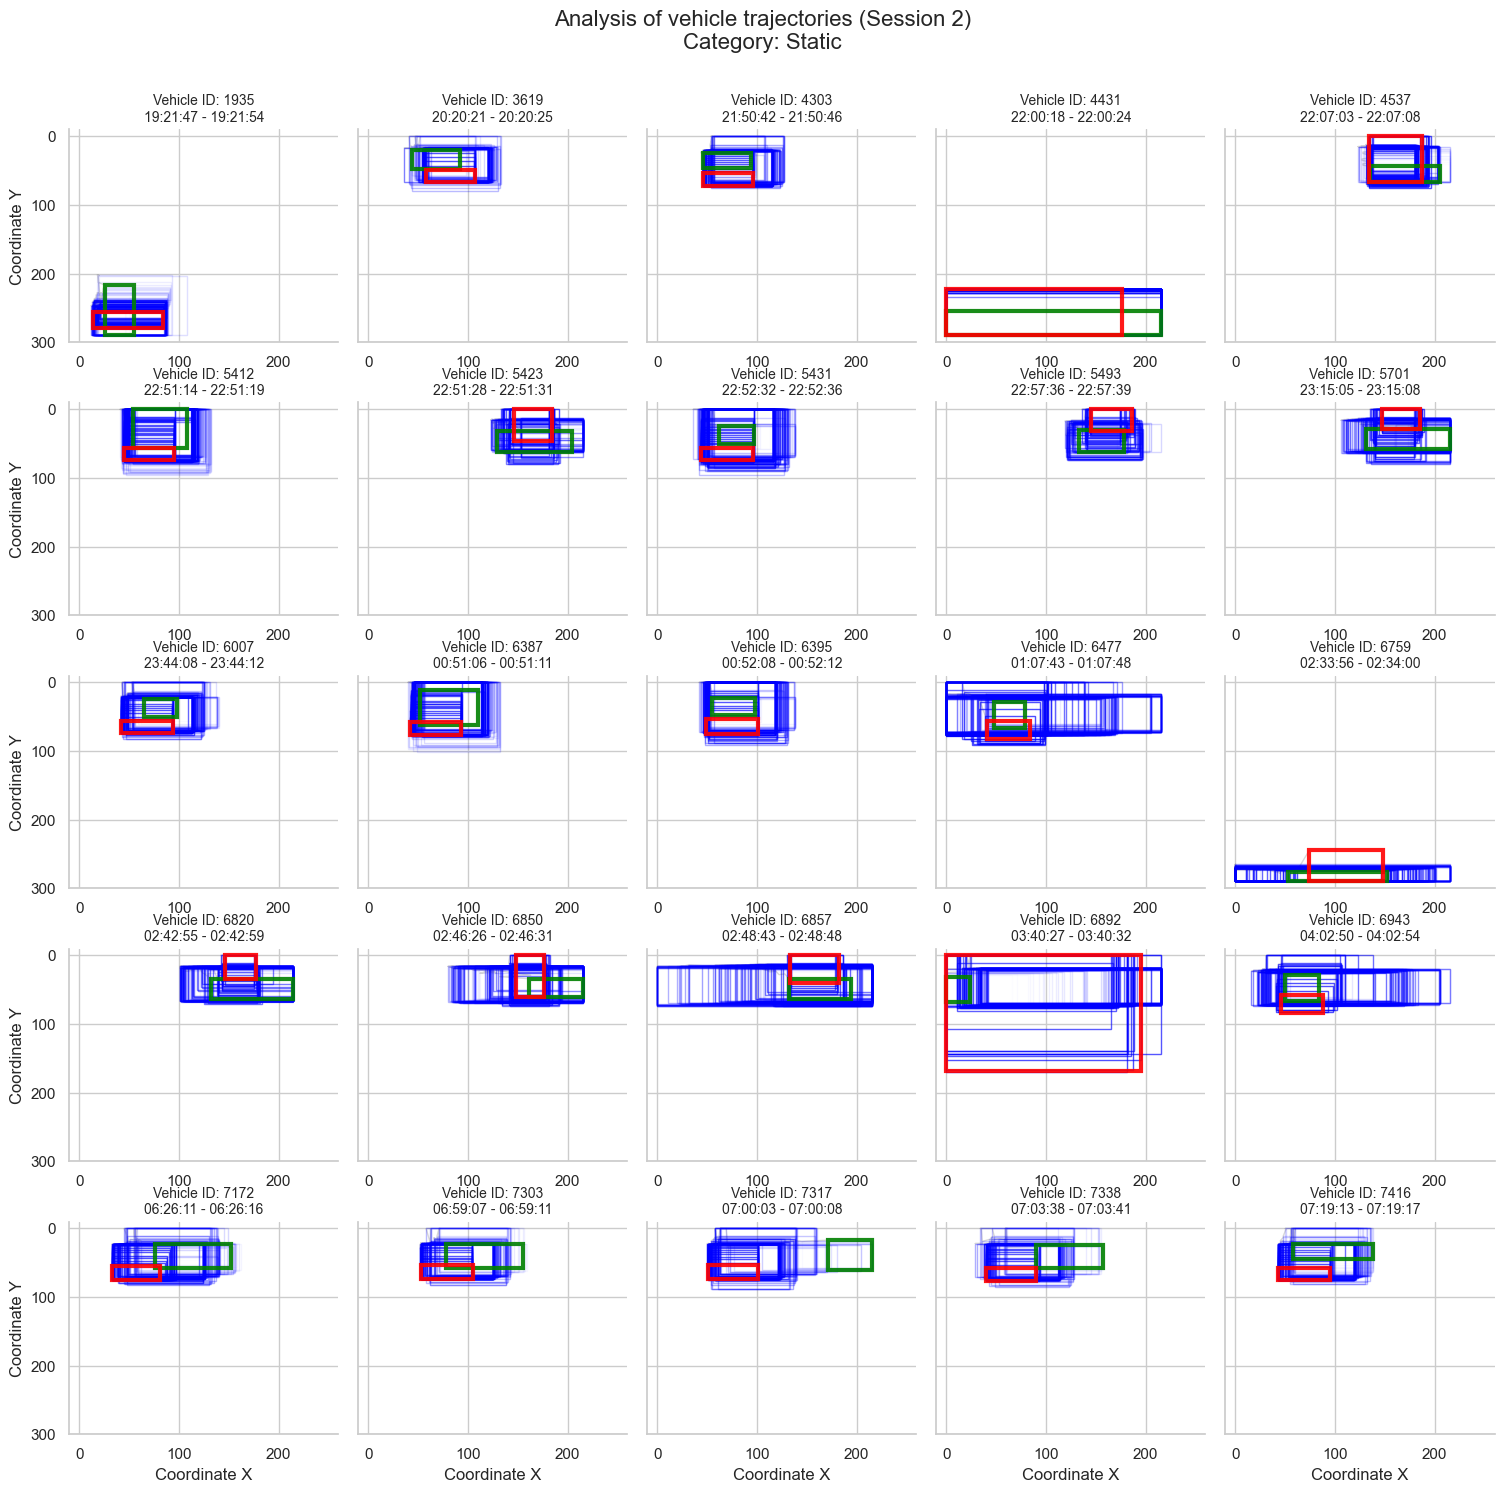

In [10]:
ids_to_plot = filtered_final_summary['vehicle_id']
plot_data = session_df[session_df['vehicle_id'].isin(ids_to_plot)]
visualize_vehicle_trajectories(plot_data, session_id=session_id_to_analyze, max_vehicles=25, min_records=20, category=filter_category)

In [11]:
plot_data.groupby('vehicle_id').agg('size')

vehicle_id
1935      101
3619       70
4303       93
4431      164
4537      159
         ... 
402062     96
402177    201
403221     95
403491    101
403749     98
Length: 1190, dtype: int64

In [12]:
merge_results = find_merging_pairs(final_summary, category_filter=['RelayCandidate', 'Partial', 'Static'])
print(f"Found pairs for merging: {len(merge_results)}")
merge_results

Search for pairs for merging: 100%|██████████| 29902/29902 [00:00<00:00, 601323.67ID/s]

Found pairs for merging: 739


,old_id,new_id,gap_sec,y_dist,size_diff_pct,old_x_start,old_y_start,old_x_end,old_y_end,new_x_start,new_y_start,new_x_end,new_y_end,old_t_start,old_t_end,new_t_start,new_t_end
0,2395,2400,0.39,23,2.3,48.6,0,48.6,38,57.0,61,57.0,255,2025-11-29 19:34:32.756998,2025-11-29 19:34:35.801374,2025-11-29 19:34:36.194726,2025-11-29 19:34:38.193299
1,2822,2824,0.15,12,3.5,49.0,0,49.0,50,59.4,62,59.4,260,2025-11-29 19:43:14.955705,2025-11-29 19:43:18.206759,2025-11-29 19:43:18.361589,2025-11-29 19:43:20.978062
2,18747,18749,0.35,31,19.3,137.0,40,137.0,0,135.0,31,135.0,0,2025-11-30 22:05:52.901088,2025-11-30 22:05:57.639148,2025-11-30 22:05:57.992510,2025-11-30 22:05:59.907946
3,21867,21873,0.74,22,8.8,26.9,0,26.9,92,38.7,70,38.7,165,2025-12-01 07:33:18.163074,2025-12-01 07:33:21.862830,2025-12-01 07:33:22.606114,2025-12-01 07:33:23.751648
4,22155,22160,0.27,18,0.1,23.8,0,23.8,33,23.3,51,23.3,264,2025-12-01 07:39:38.453759,2025-12-01 07:39:39.809394,2025-12-01 07:39:40.076063,2025-12-01 07:39:41.840095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
734,401968,401976,0.86,39,12.9,47.6,0,47.6,68,53.8,107,53.8,215,2025-12-18 08:16:20.093324,2025-12-18 08:16:22.674609,2025-12-18 08:16:23.532642,2025-12-18 08:16:26.484945
735,402991,402993,0.30,5,1.8,0.0,0,0.0,48,0.0,53,0.0,113,2025-12-18 09:25:19.343946,2025-12-18 09:25:21.512641,2025-12-18 09:25:21.814327,2025-12-18 09:25:25.263767
736,403160,403163,0.07,22,15.0,130.5,266,130.5,66,134.4,44,134.4,0,2025-12-18 09:35:14.508610,2025-12-18 09:35:16.483024,2025-12-18 09:35:16.558023,2025-12-18 09:35:18.586401
737,403461,403470,1.15,6,5.8,135.7,277,135.7,152,138.0,146,138.0,90,2025-12-18 10:06:47.850284,2025-12-18 10:06:53.009489,2025-12-18 10:06:54.156286,2025-12-18 10:06:57.430744


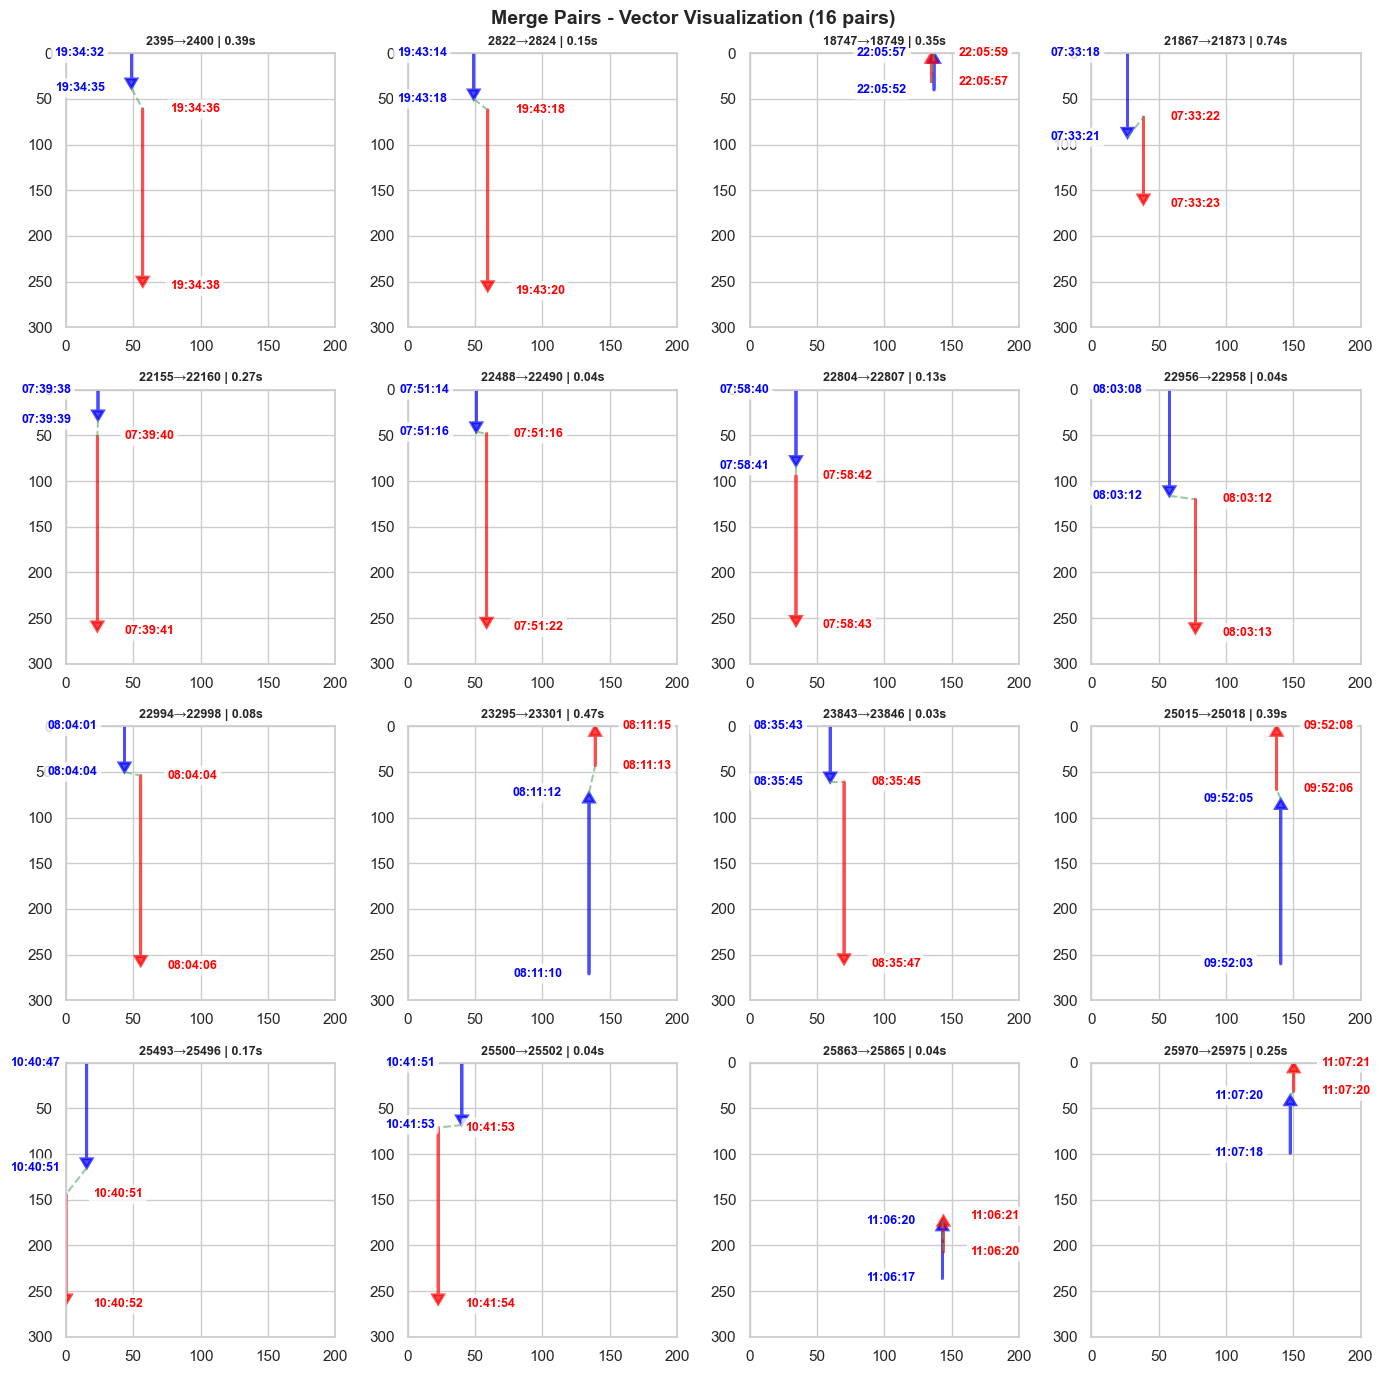

In [13]:
# Visualize
fig = visualize_merge_pairs_grid(merge_results, n_pairs=16, cols=4)
plt.show()


In [14]:
chains = build_merge_chains(merge_results)
print(f"Found {len(chains)} chains")
print(f"Longest chain has {max(len(c) for c in chains) if chains else 0} IDs")
print("\nFirst 10 chains (sorted by time):")
for i, chain in enumerate(chains[:10]):
    # Get start time for display
    first_id = chain[0]
    first_row = merge_results[merge_results['old_id'] == first_id].iloc[0] if len(merge_results[merge_results['old_id'] == first_id]) > 0 else None
    time_str = first_row['old_t_start'].strftime('%H:%M:%S') if first_row is not None else "??:??:??"
    print(f"{i+1}. [{time_str}] {' → '.join(map(str, chain))}")


Found 731 chains
Longest chain has 3 IDs

First 10 chains (sorted by time):
1. [19:34:32] 2395 → 2400
2. [19:43:14] 2822 → 2824
3. [22:05:52] 18747 → 18749
4. [07:33:18] 21867 → 21873
5. [07:39:38] 22155 → 22160
6. [07:51:14] 22488 → 22490
7. [07:58:40] 22804 → 22807
8. [08:03:08] 22956 → 22958
9. [08:04:01] 22994 → 22998
10. [08:11:10] 23295 → 23301


In [15]:
long_chains = [chain for chain in chains if len(chain) > 2]
print(f"Chains with more than 2 IDs: {len(long_chains)}")
long_chains 

Chains with more than 2 IDs: 8


[[32222, 32227, 32230],
 [35150, 35156, 35162],
 [125056, 125063, 125072],
 [125073, 125075, 125076],
 [180516, 180519, 180521],
 [190132, 190137, 190144],
 [290663, 290669, 290678],
 [346237, 346240, 346246]]

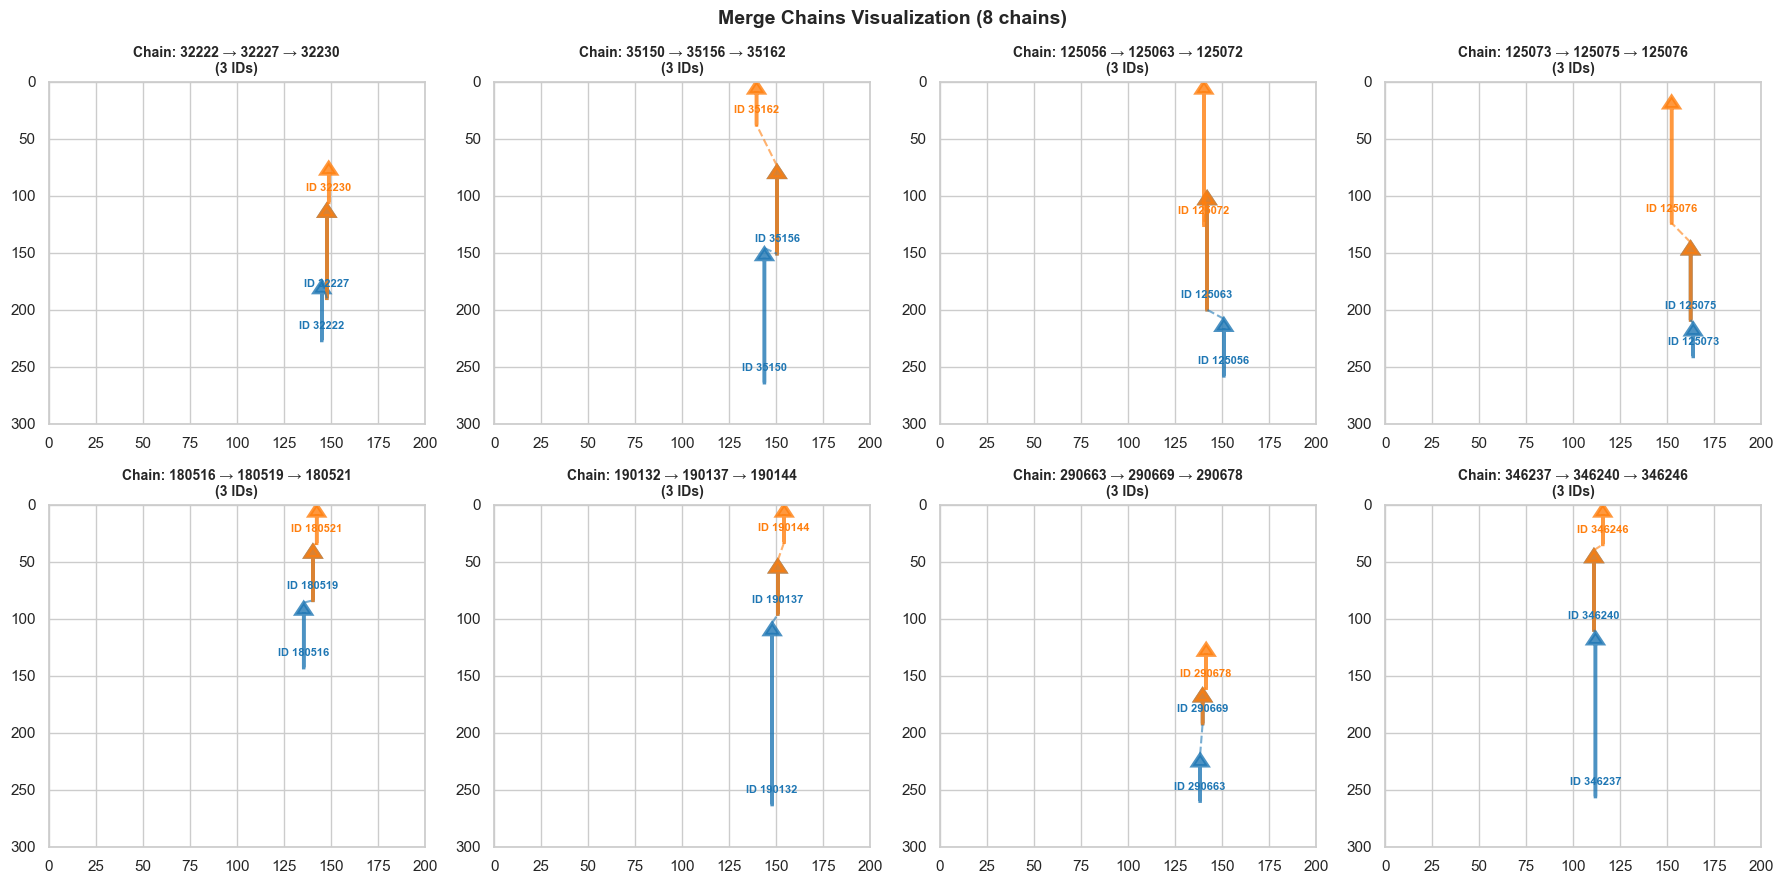

In [16]:
# Visualize chains
fig = visualize_merge_chains_grid(merge_results, long_chains, n_chains=16, cols=4)
plt.show()


In [17]:
# Applying the merge to the current session with consolidation
updated_summary = apply_merges_to_summary(final_summary, chains)

# Checking the result
print(f"Total IDs: {len(updated_summary)}")
print(f"IDs with unified_id: {updated_summary['unified_id'].notna().sum()}")
print(f"\nCategory distribution:")
print(updated_summary['category'].value_counts())
print(f"\nПриклад Merged ID (консолідовані):")
print(updated_summary[updated_summary['category'] == 'Merged'].head())

Total IDs: 403418
IDs with unified_id: 46757

Category distribution:
category
Ghost             345584
Perfect            28434
Partial            17592
RelayCandidate      9714
Static              1126
Merged               731
Flickering           237
Name: count, dtype: int64

Приклад Merged ID (консолідовані):
       session_id      vehicle_id  y_start  y_end     w_mean      w_std  \
2395            2    [2395, 2400]        0    255  71.412585  16.832262   
2821            2    [2822, 2824]        0    260  72.983333  17.886099   
18745           2  [18747, 18749]       40      0  60.352830   5.925543   
21864           2  [21867, 21873]        0    165  68.706250  21.488961   
22151           2  [22155, 22160]        0    264  42.557504   8.975191   

           h_mean      h_std  frames_count                    t_start  \
2395   129.167347  70.687469            79 2025-11-29 19:34:32.756998   
2821   134.084359  74.363903            89 2025-11-29 19:43:14.955705   
18745   57.4852

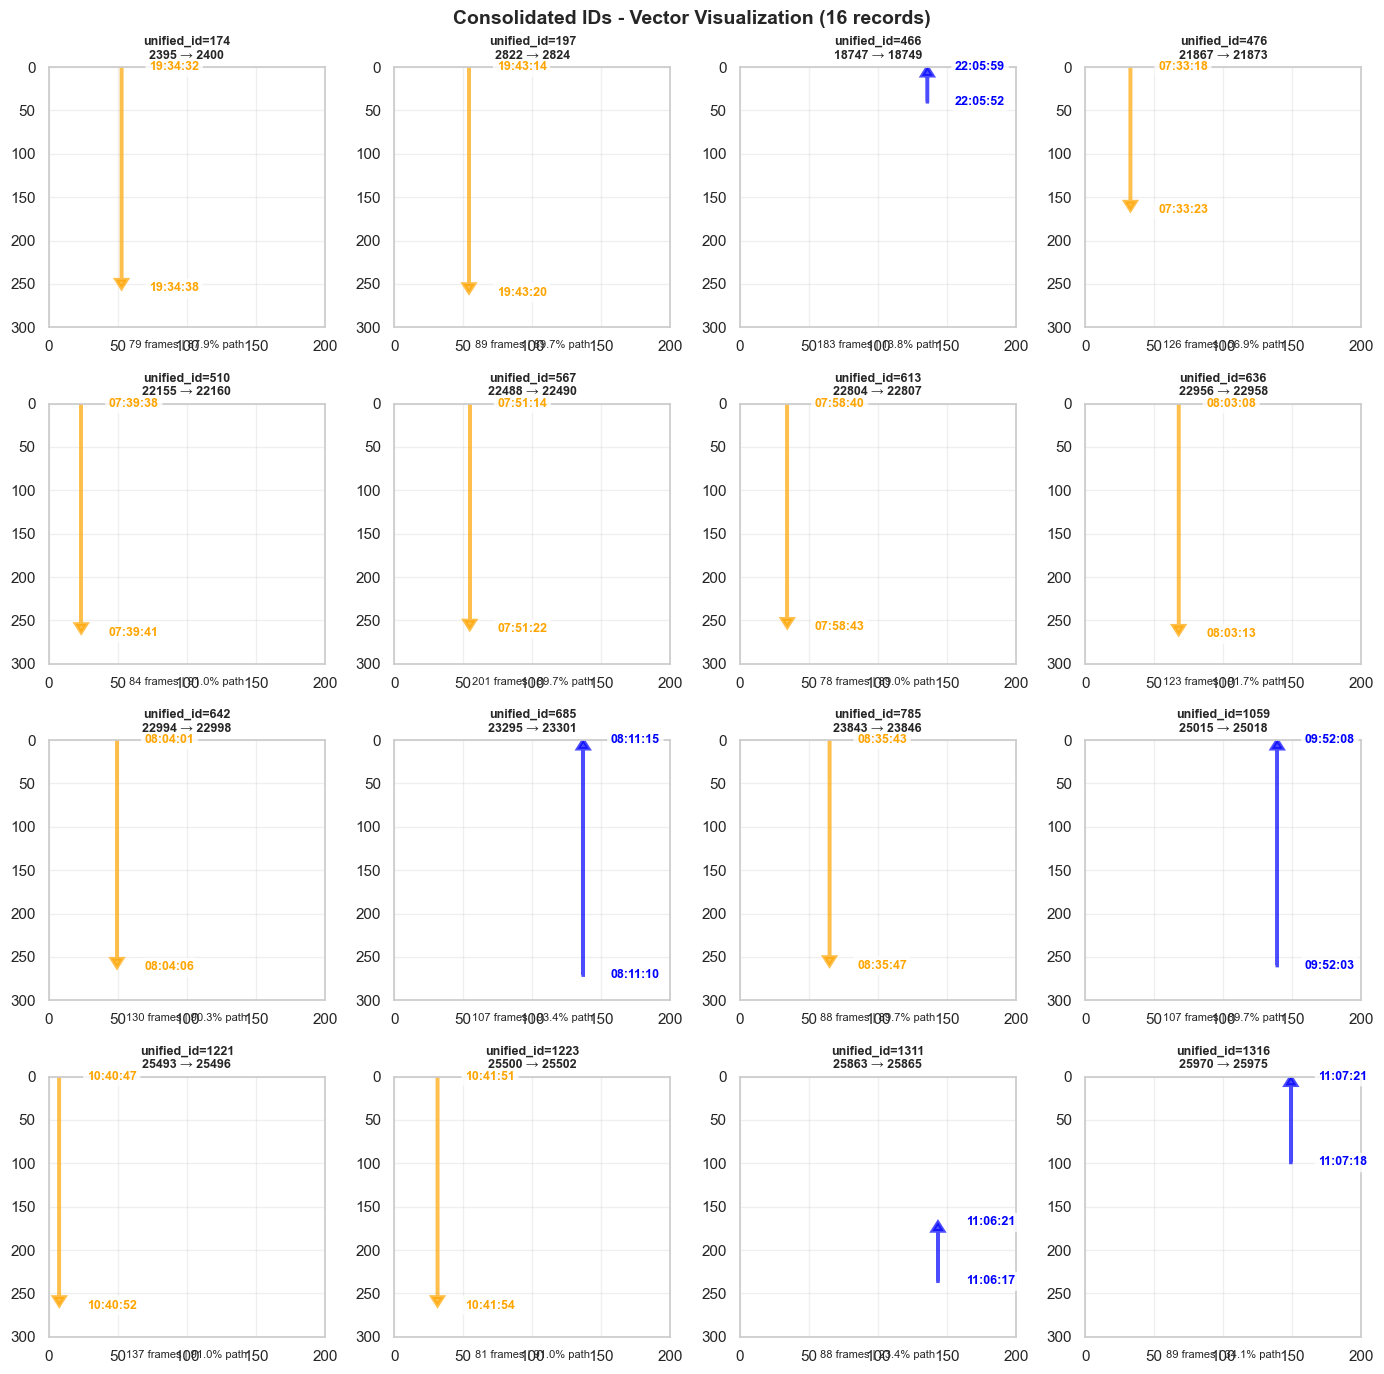

In [ ]:
# Visualisation of consolidated IDs as vectors (pure arrows)
df_to_plot = updated_summary[updated_summary['category'] == 'Merged']
fig = visualize_consolidated_merges_grid(df_to_plot, n_merges=16, cols=4)
plt.show()